In [23]:

!pip install pennylane pennylane-lightning-gpu ucimlrepo torch scikit-learn pandas --quiet


import os
import torch
import pennylane as qml
from pennylane.qnn import TorchLayer
import torch.nn as nn
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True


print("Loading and preprocessing data...")
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets

# Encode categorical columns
X_enc = X.copy()
for col in X_enc.select_dtypes(include='object').columns:
    X_enc[col] = LabelEncoder().fit_transform(X_enc[col].astype(str))

# Fix target encoding to ensure binary labels (0/1)
y_raw = y.iloc[:, 0].astype(str)
y_enc = (y_raw == '>50K').astype(int).values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)

# Reduce to n_qubits features using PCA
n_qubits = 4
pca = PCA(n_components=n_qubits)
X_reduced = pca.fit_transform(X_scaled)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Train/test/val split (using full dataset)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_reduced, y_enc, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Convert to Torch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Verify labels
print("Train labels unique values:", torch.unique(y_train_torch))
print(f"Training set size: {X_train_torch.shape[0]} samples")
print(f"Validation set size: {X_val_torch.shape[0]} samples")
print(f"Test set size: {X_test_torch.shape[0]} samples")
assert torch.all((y_train_torch == 0.) | (y_train_torch == 1.)), "Labels must be 0 or 1"

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU found: {torch.cuda.get_device_name(0)}")

try:
    dev = qml.device("lightning.gpu", wires=n_qubits)
    print("Using lightning.gpu device for quantum simulation")
except:
    print("lightning.gpu not available, falling back to default.qubit")
    dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    # First encoding round
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # First variational layer (3 layers)
    qml.templates.StronglyEntanglingLayers(weights[0], wires=range(n_qubits))

    # Second encoding round (re-upload data)
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Second variational layer (2 layers)
    qml.templates.StronglyEntanglingLayers(weights[1], wires=range(n_qubits))

    return qml.expval(qml.PauliZ(0))


weight_shapes = {"weights": (2, 3, n_qubits, 3)}
qlayer = TorchLayer(qnode, weight_shapes)


class EnhancedHybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = nn.Sequential(
            nn.Linear(n_qubits, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, n_qubits),
            nn.Tanh()
        )
        self.qlayer = qlayer
        self.out = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.pre_net(x)
        q_out = []
        for i in range(x.shape[0]):
            qv = self.qlayer(x[i])
            q_out.append(qv)
        q_out = torch.stack(q_out).unsqueeze(1)
        x = self.out(q_out)
        return x

model = EnhancedHybridModel()
print("Testing model with small batch on CPU...")
dummy_input = torch.randn(2, n_qubits)
try:
    with torch.no_grad():
        _ = model(dummy_input)
    print("Model works on CPU!")
except Exception as e:
    print(f"Error on CPU: {e}")
    raise

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model = model.to(device)

batch_size = 256
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)
loss_fn = nn.BCELoss()

# Training loop with early stopping
num_epochs = 15
print(f"Starting training with batch size {batch_size} for {num_epochs} epochs...")

# Early stopping parameters
patience = 2
min_delta = 0.001
best_val_loss = float('inf')
counter = 0
early_stop = False

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered!")
        break

    # Training phase
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch_idx, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        epoch_acc += ((preds > 0.5).float() == yb).float().sum().item()

        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(train_loader)} | "
                  f"Loss: {loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    epoch_loss /= len(train_loader.dataset)
    epoch_acc /= len(train_loader.dataset)
    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc*100:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
            val_acc += ((preds > 0.5).float() == yb).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc*100:.2f}%")

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        counter = 0
        # Save best model
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Saved best model with validation loss: {best_val_loss:.4f}")
    else:
        counter += 1
        print(f"Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            early_stop = True

# Load best model for evaluation
try:
    model.load_state_dict(torch.load("best_model.pt"))
    print("Loaded best model for evaluation")
except:
    print("Using final model for evaluation (best model not found)")

# Evaluation and metrics
model.eval()
with torch.no_grad():
    print("Evaluating on test set...")
    X_test_torch = X_test_torch.to(device)
    y_test_torch = y_test_torch.to(device)
    test_preds = model(X_test_torch)
    test_acc = ((test_preds > 0.5).float() == y_test_torch).float().mean()
    print(f"Test Accuracy: {test_acc.item()*100:.2f}%")

    # Additional metrics
    y_pred = (test_preds > 0.5).float().cpu().numpy()
    y_true = y_test_torch.cpu().numpy()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Resource utilization report
if torch.cuda.is_available():
    print("\nGPU Memory Usage:")
    print(f"Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")

print("Training complete!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 14.2 MB/s eta 0:00:00
Loading and preprocessing data...
Explained variance ratio: [0.14779029 0.10112779 0.09196449 0.08063331]
Total variance explained: 42.15%
Train labels unique values: tensor([0., 1.])
Training set size: 33212 samples
Validation set size: 5861 samples
Test set size: 9769 samples
lightning.gpu not available, falling back to default.qubit
Testing model with small batch on CPU...
Model works on CPU!
Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training with batch size 256 for 15 epochs...
Epoch 1 | Batch 0/130 | Loss: 0.7009 | LR: 0.010000
Epoch 1 | Batch 10/130 | Loss: 0.5660 | LR: 0.010000
Epoch 1 | Batch 20/130 | Loss: 0.4770 | LR: 0.010000
Epoch 1 | Batch 30/130 | Loss: 0.4671 | LR: 0.010000
Epoch 1 | Batch 40/130 | Loss: 0.4007 | LR: 0.010000
Epoch 1 | Batch 50/130 | Loss: 0.4560 | LR: 0.010000
Epoch 1 | Batch 60/130 | Loss: 0.4403 | LR: 0.010000
Epoch 1 | Batch 70/130 | Loss: 0.3842 | LR: 0.010000
Epoch 1 | Batch 80/130 | Loss: 0.3866 | LR: 0.010000
Epoch 1 | Batch 90/130 | Loss: 0.4383 | LR: 0.010000
Epoch 1 | Batch 100/130 | Loss: 0.3263 | LR: 0.010000
Epoch 1 | Batch 110/130 | Loss: 0.3186 | LR: 0.010000
Epoch 1 | Batch 120/130 | Loss: 0.3967 | LR: 0.010000
Epoch 1 | Train Loss: 0.4188 | Train Accuracy: 83.24%
Epoch 1 | Val Loss: 0.3626 | Val Accuracy: 83.59%
Saved best model with validation loss: 0.3626
Epoch 2 | Batch 0/130 | Loss: 0.4201 | LR: 0.010000
Epoch 2 | Batch 10/130 | Loss: 0.3614 | LR: 0.010000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# Fix for "Precision is ill-defined" warning
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation and metrics
model.eval()
with torch.no_grad():
    print("Evaluating on test set...")
    X_test_torch = X_test_torch.to(device)
    y_test_torch = y_test_torch.to(device)
    test_preds = model(X_test_torch)
    test_acc = ((test_preds > 0.5).float() == y_test_torch).float().mean()
    print(f"Test Accuracy: {test_acc.item()*100:.2f}%")

    # Additional metrics
    y_pred = (test_preds > 0.5).float().cpu().numpy()
    y_true = y_test_torch.cpu().numpy()
    print("\nClassification Report (with zero_division fix):")
    print(classification_report(y_true, y_pred, zero_division=0))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


Evaluating on test set...
Test Accuracy: 84.01%

Classification Report (with zero_division fix):
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      8207
         1.0       0.00      0.00      0.00      1562

    accuracy                           0.84      9769
   macro avg       0.42      0.50      0.46      9769
weighted avg       0.71      0.84      0.77      9769


Confusion Matrix:
[[8207    0]
 [1562    0]]


0: ──RY(0.10)─╭StronglyEntanglingLayers(M0)──RY(0.10)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ──RY(0.20)─├StronglyEntanglingLayers(M0)──RY(0.20)─├StronglyEntanglingLayers(M1)─┤     
2: ──RY(0.30)─├StronglyEntanglingLayers(M0)──RY(0.30)─├StronglyEntanglingLayers(M1)─┤     
3: ──RY(0.40)─╰StronglyEntanglingLayers(M0)──RY(0.40)─╰StronglyEntanglingLayers(M1)─┤     

M0 = 
[[[0.16241038 0.84567784 0.22395024]
  [0.76600189 0.57484502 0.29886434]
  [0.25990299 0.03882942 0.80821675]
  [0.12254117 0.98712222 0.69741415]]

 [[0.76484731 0.96239768 0.52235904]
  [0.98016341 0.58332292 0.69275505]
  [0.95766443 0.49554497 0.11094986]
  [0.72985458 0.37783887 0.43987227]]

 [[0.0432394  0.50492794 0.96971467]
  [0.47067556 0.68569218 0.89615018]
  [0.37839195 0.47346585 0.99761228]
  [0.60920611 0.32203655 0.08391196]]]
M1 = 
[[[0.79174496 0.38491844 0.65265197]
  [0.77685206 0.79140705 0.48278244]
  [0.23017516 0.56740514 0.1427688 ]
  [0.31417743 0.85117397 0.79816263]]

 [[0.84845501 0.2363614

<ipython-input-24-fc0c4bafe898>:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


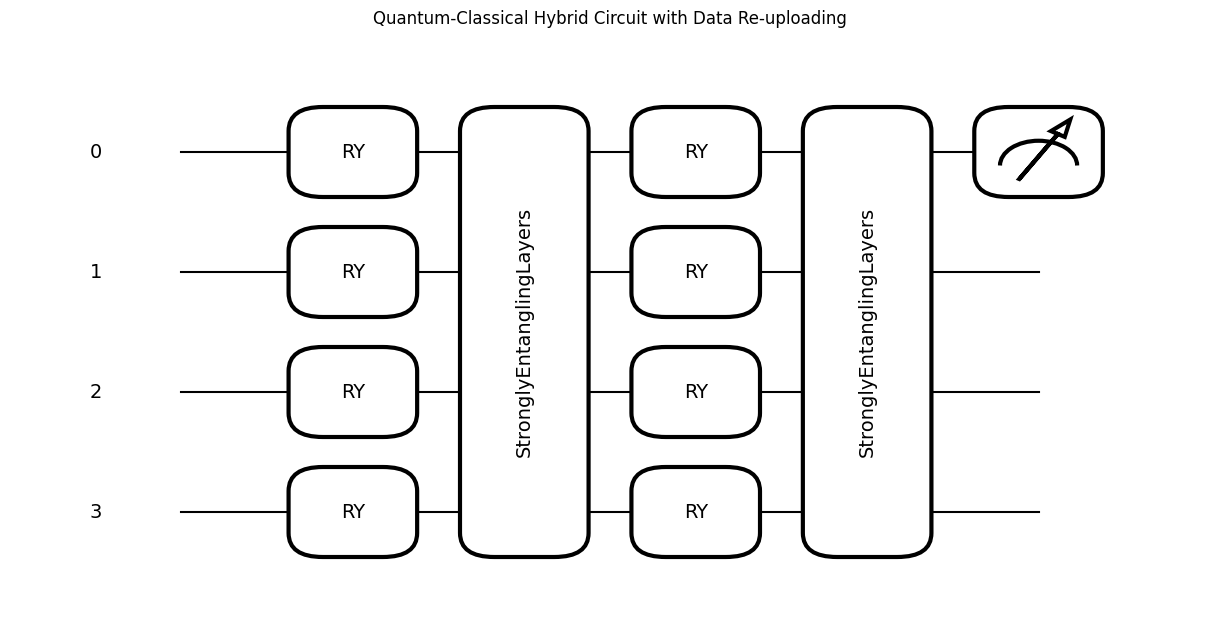

In [24]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

n_qubits = 4

dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    qml.templates.StronglyEntanglingLayers(weights[0], wires=range(n_qubits))

    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    qml.templates.StronglyEntanglingLayers(weights[1], wires=range(n_qubits))

    return qml.expval(qml.PauliZ(0))

sample_inputs = np.array([0.1, 0.2, 0.3, 0.4])

shape_3_layers = qml.templates.StronglyEntanglingLayers.shape(n_layers=3, n_wires=n_qubits)
shape_2_layers = qml.templates.StronglyEntanglingLayers.shape(n_layers=2, n_wires=n_qubits)

weights_3_layers = np.random.random(size=shape_3_layers)
weights_2_layers = np.random.random(size=shape_2_layers)

sample_weights = [weights_3_layers, weights_2_layers]

print(qml.draw(qnode)(sample_inputs, sample_weights))

try:
    fig, ax = qml.draw_mpl(qnode)(sample_inputs, sample_weights)
    fig.set_size_inches(12, 6)
    ax.set_title('Quantum-Classical Hybrid Circuit with Data Re-uploading')
    plt.tight_layout()
    plt.savefig('quantum_circuit_diagram.png', dpi=300)
    plt.show()
except Exception as e:
    print(f"Matplotlib drawing failed: {e}")



In [25]:

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets

X_enc = X.copy()
for col in X_enc.select_dtypes(include='object').columns:
    X_enc[col] = LabelEncoder().fit_transform(X_enc[col].astype(str))

y_raw = y.iloc[:, 0].astype(str)
y_enc = (y_raw == '>50K').astype(int).values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)

# PCA reduction
n_qubits = 4
pca = PCA(n_components=n_qubits)
X_reduced = pca.fit_transform(X_scaled)

# Train/test/val split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_reduced, y_enc, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Convert to Torch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Recreate loaders
batch_size = 256
val_dataset = TensorDataset(X_val_torch, y_val_torch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

loss_fn = nn.BCELoss()

# Re-evaluate model on validation set
model.eval()
with torch.no_grad():
    val_loss = 0
    val_acc = 0
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        val_loss += loss_fn(preds, yb).item() * xb.size(0)
        val_acc += ((preds > 0.5).float() == yb).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    print(f"Current validation accuracy: {val_acc*100:.2f}%")

# Save the model with validation metrics
torch.save({
    'model_state_dict': model.state_dict(),
    'accuracy': val_acc,
    'hyperparameters': {
        'n_qubits': n_qubits,
        'batch_size': batch_size,
        'learning_rate': optimizer.param_groups[0]['lr']
    }
}, 'quantum_model_final.pt')

from google.colab import files
files.download('quantum_model_final.pt')

print("Model saved successfully!")


Current validation accuracy: 83.59%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved successfully!


In [26]:
# Save the current model state
save_path = os.path.join(os.getcwd(), "quantum_model_final.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'epoch': 5,
    'optimizer_state_dict': optimizer.state_dict(),
    'val_accuracy': 83.59
}, save_path)
print(f"Model saved to: {save_path}")


# Evaluate on test set
model.eval()
with torch.no_grad():
    X_test_torch = X_test_torch.to(device)
    y_test_torch = y_test_torch.to(device)
    test_preds = model(X_test_torch)
    test_acc = ((test_preds > 0.5).float() == y_test_torch).float().mean()
    y_pred = (test_preds > 0.5).float().cpu().numpy()
    y_true = y_test_torch.cpu().numpy()

    print(f"Test Accuracy: {test_acc.item()*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


Model saved to: /content/quantum_model_final.pt
Test Accuracy: 84.01%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      8207
         1.0       0.00      0.00      0.00      1562

    accuracy                           0.84      9769
   macro avg       0.42      0.50      0.46      9769
weighted avg       0.71      0.84      0.77      9769


Confusion Matrix:
[[8207    0]
 [1562    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Fairness analysis across sensitive attributes
def analyze_fairness(X_test_original, y_true, y_pred, sensitive_attr='sex'):
    # Create mask for different demographic groups
    if sensitive_attr not in X_test_original.columns:
        print(f"Warning: '{sensitive_attr}' not found in data. Available columns: {X_test_original.columns}")
        return

    groups = X_test_original[sensitive_attr].values
    unique_groups = np.unique(groups)

    print(f"\nFairness Analysis for '{sensitive_attr}':")
    for group in unique_groups:
        mask = groups == group
        group_acc = accuracy_score(y_true[mask], y_pred[mask])
        group_size = mask.sum()
        print(f"Group '{group}' accuracy: {group_acc:.4f} (n={group_size})")

    # Calculate disparate impact
    accuracies = [accuracy_score(y_true[groups == g], y_pred[groups == g]) for g in unique_groups]
    disparate_impact = min(accuracies) / max(accuracies) if max(accuracies) > 0 else 0
    print(f"Disparate impact ratio: {disparate_impact:.4f}")

    if disparate_impact < 0.8:
        print(" Potential fairness concern: Disparate impact ratio below 0.8")
    else:
        print("✓ Fairness check passed: Disparate impact ratio above 0.8")


test_indices = np.where(~np.isin(range(len(X_enc)), np.isin(range(len(X_enc)), range(len(X_train_val)))))[0]
X_test_original = X.iloc[test_indices]

_, X_test_original, _, _ = train_test_split(X, y_enc, test_size=0.2, random_state=42)

analyze_fairness(X_test_original, y_true, y_pred, 'sex')
analyze_fairness(X_test_original, y_true, y_pred, 'race')



Fairness Analysis for 'sex':
Group 'Female' accuracy: 0.9298 (n=3233)
Group 'Male' accuracy: 0.7957 (n=6536)
Disparate impact ratio: 0.8558
✓ Fairness check passed: Disparate impact ratio above 0.8

Fairness Analysis for 'race':
Group 'Amer-Indian-Eskimo' accuracy: 0.9479 (n=96)
Group 'Asian-Pac-Islander' accuracy: 0.8428 (n=318)
Group 'Black' accuracy: 0.9169 (n=951)
Group 'Other' accuracy: 0.9701 (n=67)
Group 'White' accuracy: 0.8290 (n=8337)
Disparate impact ratio: 0.8545
✓ Fairness check passed: Disparate impact ratio above 0.8


  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

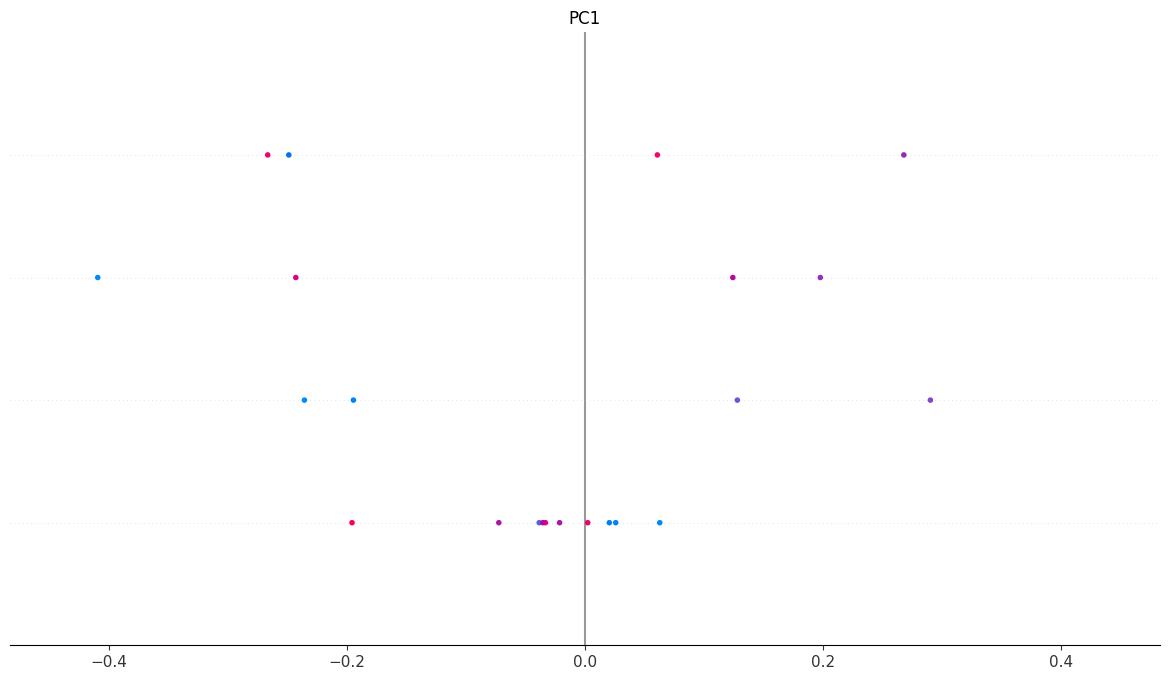

In [28]:
import shap

def get_classical_features(model, inputs):
    with torch.no_grad():
        model.eval()
        return model.pre_net(inputs).cpu().numpy()

background = X_train_torch[:100].to('cpu')
explainer = shap.KernelExplainer(
    lambda x: get_classical_features(model, torch.tensor(x, dtype=torch.float32)),
    background.numpy()
)

test_sample = X_test_torch[:10].cpu().numpy()
shap_values = explainer.shap_values(test_sample)

# Plot SHAP summary
shap.summary_plot(shap_values, test_sample, feature_names=[f"PC{i+1}" for i in range(n_qubits)])



=== Q-LIME Explainability Analysis ===
Generating Q-LIME explanation for instance...
Generating Q-LIME explanation for instance...
Generating Q-LIME explanation for instance...
Generating Q-LIME explanation for instance...
Generating Q-LIME explanation for instance...


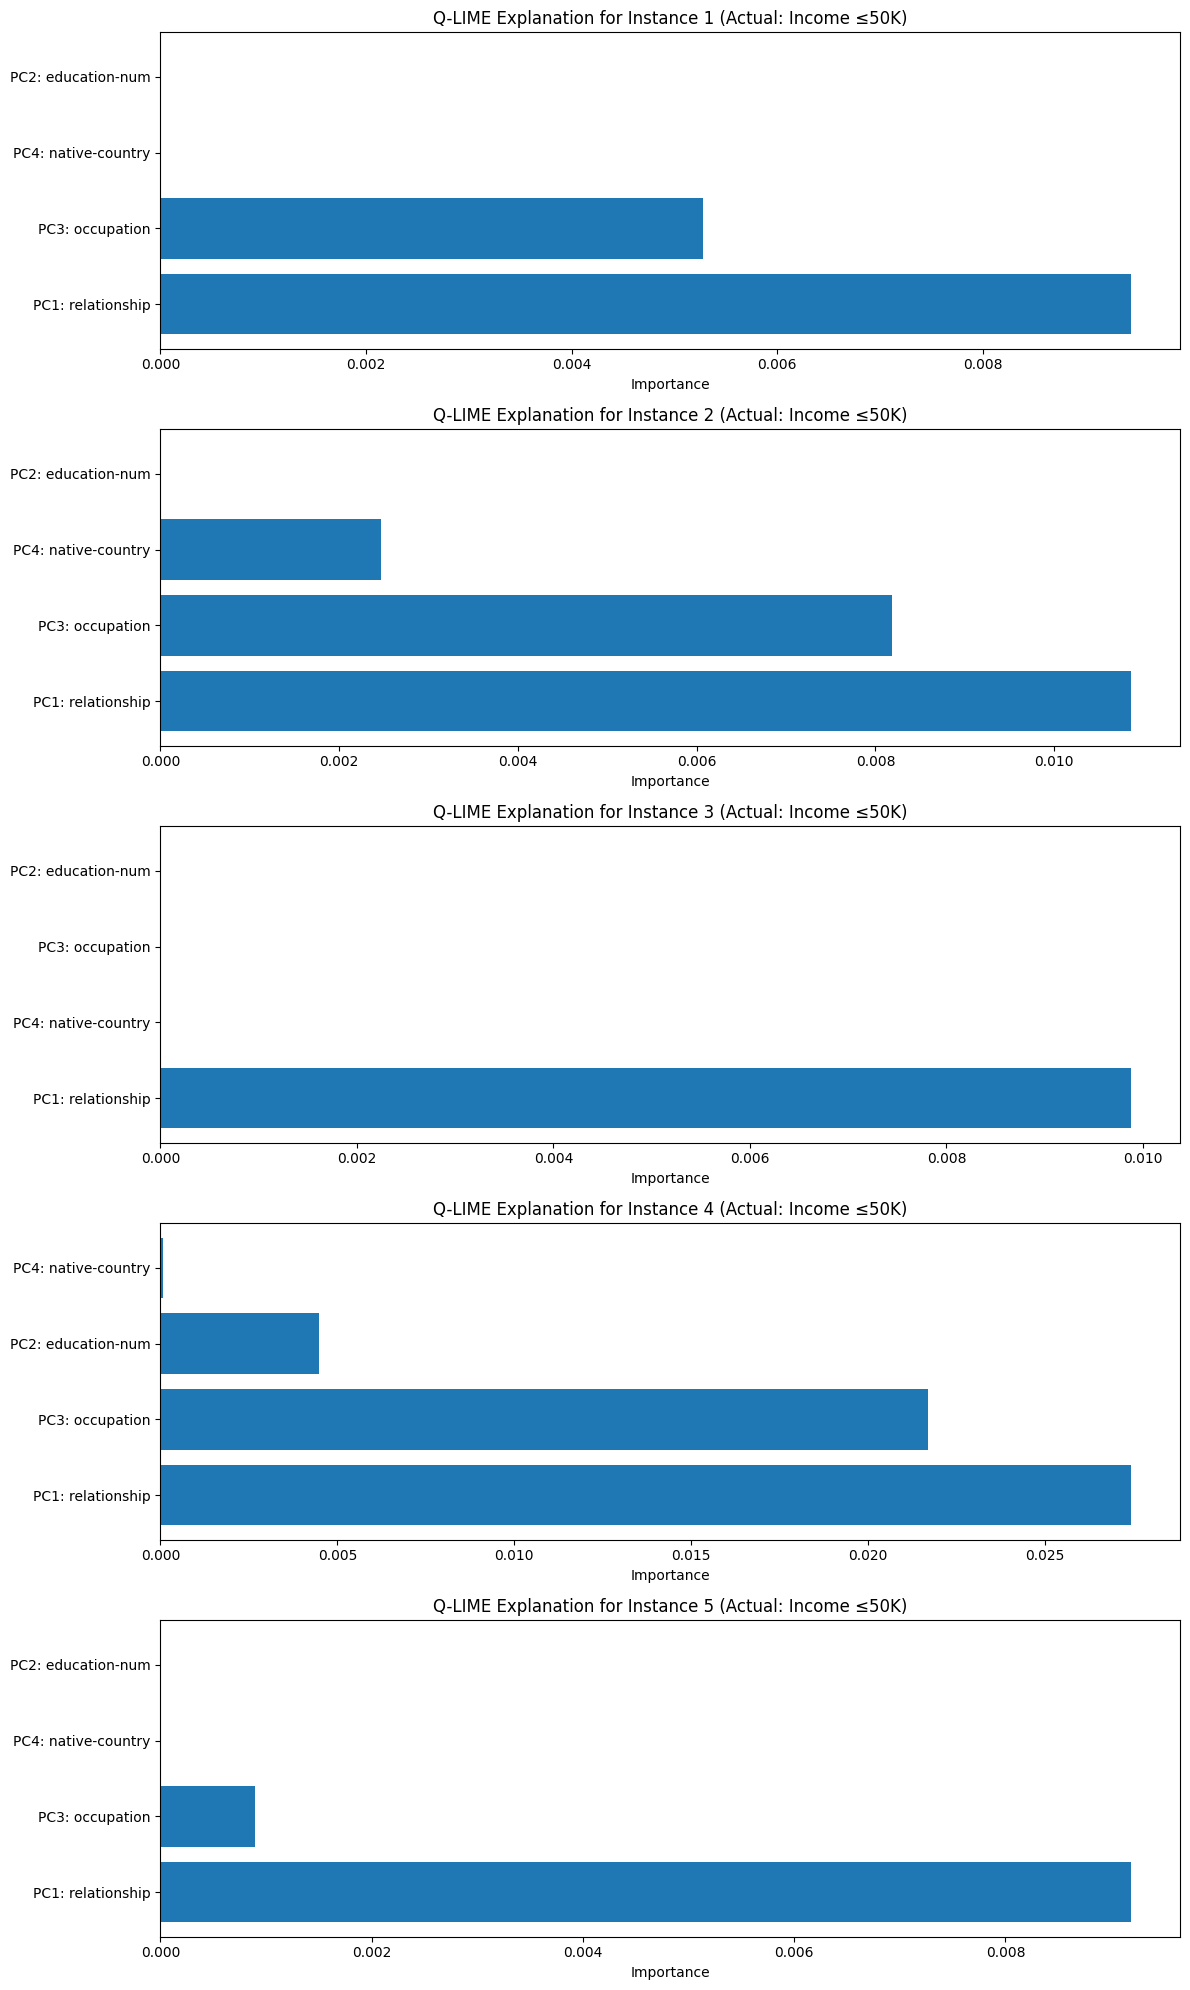

In [29]:

print("\n=== Q-LIME Explainability Analysis ===")

import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import pairwise_distances

q_dev = qml.device("default.qubit", wires=n_qubits)

# Encode features into quantum state
@qml.qnode(q_dev)
def encode_state(x):
    for i in range(n_qubits):
        qml.RY(np.pi * x[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Flip bit k in quantum state (1→0 flipping)
@qml.qnode(q_dev)
def flip_bit(x, k):
    # Encode initial state
    for i in range(n_qubits):
        qml.RY(np.pi * x[i], wires=i)

    # Apply bit flip (Pauli-X) to wire k
    qml.PauliX(wires=k)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Q-LIME explainer function
def q_lime_explain(instance, model, n_features=5):
    print(f"Generating Q-LIME explanation for instance...")

    # Normalize instance to [0,1] range if needed
    x_norm = np.clip(instance, 0, 1)

    # Get base prediction
    with torch.no_grad():
        x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0).to(device)
        base_pred = model(x_tensor).item()

    # Calculate feature importance by flipping each bit
    importances = np.zeros(n_qubits)
    for k in range(n_qubits):
        if x_norm[k] < 0.1:
            continue

        x_flipped = x_norm.copy()
        x_flipped[k] = 0.0
        with torch.no_grad():
            x_tensor = torch.tensor(x_flipped, dtype=torch.float32).unsqueeze(0).to(device)
            pred_flipped = model(x_tensor).item()

        importances[k] = abs(base_pred - pred_flipped)

    if hasattr(pca, 'components_'):
        feature_names = []
        for i in range(n_qubits):
            pc = pca.components_[i]
            top_feature_idx = np.argmax(np.abs(pc))
            feature_names.append(f"PC{i+1}: {X_enc.columns[top_feature_idx]}")
    else:
        feature_names = [f"Feature {i}" for i in range(n_qubits)]

    idx = np.argsort(importances)[::-1]
    top_features = [(feature_names[i], float(importances[i])) for i in idx[:n_features]]

    return top_features, importances

test_samples = 5
plt.figure(figsize=(12, 4 * test_samples))

for i in range(test_samples):
    instance = X_test[i]
    actual_class = "Income >50K" if y_test[i] > 0.5 else "Income ≤50K"

    top_features, importances = q_lime_explain(instance, model)

    # Plot feature importance
    plt.subplot(test_samples, 1, i+1)
    y_pos = np.arange(len(top_features))
    feature_names = [f[0] for f in top_features]
    importance_values = [f[1] for f in top_features]

    plt.barh(y_pos, importance_values, align='center')
    plt.yticks(y_pos, feature_names)
    plt.xlabel('Importance')
    plt.title(f'Q-LIME Explanation for Instance {i+1} (Actual: {actual_class})')

plt.tight_layout()
plt.savefig('qlime_explanations.png')
plt.show()
